mock sensor data, mock processed data
mock historical data (1 year)  
mock live data (from the last day in db to now + ongoing data)  


seat availability  
crowd density  
temperature  





## crowd density
#### capacity constraints:  
0 <= total passenger count < carriage capacity  
during peak hour - occupancy rate - 70-100%
off peak - occupancy rate - 0 - 70%

#### time constraint:  
train operating hours - 530-0015

#### patterns:  
peak hours weekdays - 7am - 930am, 530pm - 830pm  
peak hours weekend - 8am - 9am, 630pm-830pm  
peak hour train frequency (len of interval) - 2-3 minutes  
off peak train frequency (len of interval) - 5-8 minutes  


## seat availability
since we have 20 seats in a carriage with capacity of 40  
if crowd density is above 50%, assume no empty seat  
if crowd density is below 50%, no of seats available should be min (20 - crowd density), max 20  
lets say crowd density = 25%, means there are 10 passengers  
no of seats available should be at least 10 (20 - 10), at most 20  


## temperature
use monthly average data
take into account rain/ sun, day/ night
take into account airconditioning


#### noise - breakdowns, service/ maintenance time (<= 5%) (not doing)
peak period noise - low
non-peak noise - high



simulate for one carriage first

simulate timestamp

In [ ]:
# from random import randrange
# import datetime


# def random_date(start, l):
#     current = start
#     while l >= 0:
#         current = current + datetime.timedelta(minutes=randrange(10))
#         yield current
#         l -= 1


# startDate = datetime.datetime(2022, 9, 20, 13, 00)


# for x in (list(random_date(startDate, 10))):
#     print(x.strftime("%d/%m/%y %H:%M"))


# START

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import datetime

passenger_congestion_weekday = pd.read_csv("../data/test/passenger_congestion_rate_weekday.csv")
passenger_congestion_weekend = pd.read_csv("../data/test/passenger_congestion_rate_weekend.csv")

daily_temp_raw = pd.read_csv("../data/test/daily_temperature.csv")


## Constants

In [29]:
# general
INTERVAL_MINUTES = 3
SECONDS_BIN = [sec for sec in range(0, 24*60*60, INTERVAL_MINUTES*60)]
CLOSING_TIME = 0.25 * 60 * 60
OPENING_TIME = 5.5 * 60 * 60
START_DATE = int(datetime.datetime(2021, 10, 1).timestamp())
today = datetime.datetime.today()
END_DATE = int(datetime.datetime(today.year, today.month, today.day).timestamp())
CARRIAGE_CAPACITY = 40
CARRIAGE_IDS = [i+1 for i in range(4)]


# Crowdedness
WD_NON_PEAK_VARIATION = 0.15
WD_PEAK_VARIATION = 0.05
WE_NON_PEAK_VARIATION = 0.25
WE_PEAK_VARIATION = 0.1
# peak period weekdays: 7am - 930am, 530-830pm
WD_PEAK_1_START = 7 * 60 * 60
WD_PEAK_1_END = 9.5 * 60 * 60 
WD_PEAK_2_START = 17.5 * 60 * 60
WD_PEAK_2_END = 20.5 * 60 * 60
# peak period weekend: 8am - 930am, 630-830pm
WE_PEAK_1_START = 8 * 60 * 60
WE_PEAK_1_END = 9.5 * 60 * 60
WE_PEAK_2_START = 18.5 * 60 * 60 
WE_PEAK_2_END = 20.5 * 60 * 60



# temperature
HOT_MONTHS = [1,2,3,7,8]
COLD_MONTHS = [11,12]
COLDEST_TEMP = 23
HOTTEST_TEMP = 30
TEMP_VARIATION = 0.10


# seat availability
SEATS_PER_CARRIAGE = 20


## shared functions

In [30]:

def convert_float_to_seconds(time_float):
    hour = math.floor(time_float)
    minute = 60 * (time_float - hour)
    return hour * 60 * 60 + minute * 60


def generate_random_times_in_day():
    START = 0
    END = 1 * 60 * 60 * 24
    K = int(86400 / 300)
    time_in_s = random.sample(range(START, END), K)
    return sorted(set(time_in_s))


def convert_epoch_to_datetime(epoch_time: int):
    return datetime.datetime.fromtimestamp(epoch_time).strftime('%Y-%m-%d %H:%M:%S')



def get_seed_value_from_time(seed_value_df, time_in_day_s):
    if 0 <= time_in_day_s <= CLOSING_TIME or OPENING_TIME <= time_in_day_s <= 23.999 * 60 * 60:
        result_index = seed_value_df['time_bin_s'].sub(time_in_day_s).abs().idxmin()
        return seed_value_df.rate[result_index]
    else: return 0

def create_seed_data_from_raw_data(raw_data_df):
    raw_data_df["time"] = raw_data_df["time"].apply(convert_float_to_seconds)
    raw_data_df["time_bin"] = np.digitize(raw_data_df["time"], SECONDS_BIN)
    raw_data_seeder = raw_data_df.groupby("time_bin").mean().reset_index()
    raw_data_seeder["time_bin_s"] = raw_data_seeder["time_bin"] * INTERVAL_MINUTES * 60
    raw_data_seeder.drop(columns=["time", "time_bin"], inplace=True)
    raw_data_seeder.rename(columns={"value":"rate"}, inplace=True)
    raw_data_seeder = raw_data_seeder[["time_bin_s", "rate"]]
    return raw_data_seeder

congestion_weekday_seeder = create_seed_data_from_raw_data(passenger_congestion_weekday)
congestion_weekend_seeder = create_seed_data_from_raw_data(passenger_congestion_weekend)
daily_temp_seeder  = create_seed_data_from_raw_data(daily_temp_raw) 



## Congestion

In [31]:


def generate_random_congestion_rate(time_in_day_s: int, is_weekday: bool, seed_value: float):
    if is_weekday:
        if WD_PEAK_1_START <= time_in_day_s <= WD_PEAK_1_END or WD_PEAK_2_START <= time_in_day_s <= WD_PEAK_2_END:
            upper_bound = seed_value * (1 + WD_PEAK_VARIATION)
            lower_bound = seed_value * (1 - WD_PEAK_VARIATION)
        else:
            upper_bound = seed_value * (1 + WD_NON_PEAK_VARIATION)
            lower_bound = seed_value * (1 - WD_NON_PEAK_VARIATION)
    else:
        if WE_PEAK_1_START <= time_in_day_s <= WE_PEAK_1_END or WE_PEAK_2_START <= time_in_day_s <= WE_PEAK_2_END:
            upper_bound = seed_value * (1 + WE_PEAK_VARIATION)
            lower_bound = seed_value * (1 - WE_PEAK_VARIATION)
        else:
            upper_bound = seed_value * (1 + WE_NON_PEAK_VARIATION)
            lower_bound = seed_value * (1 - WE_NON_PEAK_VARIATION)

    if upper_bound > 100: upper_bound = 100
    if lower_bound > 100: lower_bound = 100
    if upper_bound < 0: upper_bound = 0
    if lower_bound < 0: lower_bound = 0

    return random.uniform(lower_bound, upper_bound)



def generate_random_values_daily(seed_df, times_in_s, is_weekday):
    random_vals = []
    for time_in_s in times_in_s:
        seed_val = get_seed_value_from_time(seed_df, time_in_s)
        random_val = generate_random_congestion_rate(time_in_s, is_weekday, seed_val)
        random_vals.append(random_val)
    return random_vals


In [32]:

def generate_historical_congestion_data(weekday_data_seeder, weekend_data_seeder, carriage_id):
    full_df = pd.DataFrame()

    for day in range(START_DATE, END_DATE, 86400):
        random_times = generate_random_times_in_day()
        is_weekday = datetime.datetime.fromtimestamp(day).weekday() in [i for i in range(5)]
        if is_weekday:
            random_vals = generate_random_values_daily(weekday_data_seeder, random_times, is_weekday)
        else:
            random_vals = generate_random_values_daily(weekend_data_seeder, random_times, is_weekday)
            
        daily_congestion_df = pd.DataFrame({"time": random_times, "value": random_vals})
        daily_congestion_df.time = daily_congestion_df.time + day
        full_df = pd.concat([full_df, daily_congestion_df], axis=0)
    full_df["carriage_id"] = carriage_id
    return full_df



def generate_historical_congestion_data_all_carriages(congestion_weekday_seeder, congestion_weekend_seeder):
    all_carriages = pd.DataFrame()
    for carriage in CARRIAGE_IDS:
        carriage_df = generate_historical_congestion_data(congestion_weekday_seeder, congestion_weekend_seeder, carriage)
        
        capacity = CARRIAGE_CAPACITY * random.uniform(0.80, 0.95) if carriage in [1, 4] else CARRIAGE_CAPACITY
        carriage_df["value"] = capacity * carriage_df["value"] * 0.01
        all_carriages = pd.concat([all_carriages, carriage_df])

    all_carriages["value"] = all_carriages["value"].astype(int)

    # all_carriages.time = all_carriages.time.apply(convert_epoch_to_datetime)
    all_carriages["comfort_indicator"] = "crowd"
    all_carriages.rename(columns={"time": "timestamp"}, inplace=True)
    return all_carriages


crowd_historical_df = generate_historical_congestion_data_all_carriages(congestion_weekday_seeder, congestion_weekend_seeder)
crowd_historical_df


,timestamp,value,carriage_id,comfort_indicator
0,1633017908,2,1,crowd
1,1633018162,2,1,crowd
2,1633018505,0,1,crowd
3,1633018590,0,1,crowd
4,1633018903,0,1,crowd
...,...,...,...,...
283,1666884733,6,4,crowd
284,1666884754,4,4,crowd
285,1666884819,5,4,crowd
286,1666886098,4,4,crowd


array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

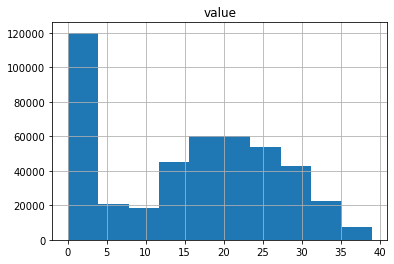

In [33]:
# crowd_historical_df.to_csv("../data/intermediate/crowd_historical.csv", encoding="utf_8_sig", index=False)
crowd_historical_df.value.describe()
crowd_historical_df.hist("value")

## Temperature

In [34]:

def generate_random_temp(time_in_day_s: int, epoch_day: int, seed_value: float):

    if datetime.datetime.fromtimestamp(epoch_day).month in HOT_MONTHS:
        upper_bound = seed_value * (1 + TEMP_VARIATION)
        lower_bound = seed_value
    elif datetime.datetime.fromtimestamp(epoch_day).month in COLD_MONTHS:
        upper_bound = seed_value 
        lower_bound = seed_value * (1 - TEMP_VARIATION)
    else:
        upper_bound = seed_value * (1 + 0.5 * TEMP_VARIATION)
        lower_bound = seed_value * (1 - 0.5 * TEMP_VARIATION)

    if upper_bound > HOTTEST_TEMP: upper_bound = HOTTEST_TEMP
    if lower_bound > HOTTEST_TEMP: lower_bound = HOTTEST_TEMP
    if upper_bound < COLDEST_TEMP: upper_bound = COLDEST_TEMP
    if lower_bound < COLDEST_TEMP: lower_bound = COLDEST_TEMP

    return random.uniform(lower_bound, upper_bound)



def generate_random_temp_values_daily(seed_df, times_in_s, epoch_day: int):
    random_vals = []
    for time_in_s in times_in_s:
        seed_val = get_seed_value_from_time(seed_df, time_in_s)
        random_val = generate_random_temp(time_in_s, epoch_day, seed_val)
        random_vals.append(random_val)
    return random_vals


In [35]:
def generate_historical_temp_data(temp_data_seeder, carriage_id):
    full_df = pd.DataFrame()

    for day in range(START_DATE, END_DATE, 86400):
        random_times = generate_random_times_in_day()
        random_vals = generate_random_temp_values_daily(temp_data_seeder, random_times, day)
            

        daily_temp_df = pd.DataFrame({"time": random_times, "value": random_vals})
        daily_temp_df.time = daily_temp_df.time + day
        full_df = pd.concat([full_df, daily_temp_df], axis=0)
    full_df["carriage_id"] = carriage_id
    return full_df

def generate_historical_temp_all_carriages(daily_temp_seeder):
    all_carriages = pd.DataFrame()
    for carriage in CARRIAGE_IDS:
        carriage_df = generate_historical_temp_data(daily_temp_seeder, carriage)
        
        carriage_df["value"] = carriage_df["value"] * random.uniform(0.95, 1.0) if carriage in [1, 4] else carriage_df["value"]
        all_carriages = pd.concat([all_carriages, carriage_df])

    all_carriages["value"] = all_carriages["value"].astype(float)

    # all_carriages.time = all_carriages.time.apply(convert_epoch_to_datetime)
    all_carriages["comfort_indicator"] = "temperature"
    all_carriages.rename(columns={"time": "timestamp"}, inplace=True)
    return all_carriages

historical_temp = generate_historical_temp_all_carriages(daily_temp_seeder)
historical_temp


,timestamp,value,carriage_id,comfort_indicator
0,1633017914,25.215265,1,temperature
1,1633017954,27.170984,1,temperature
2,1633017956,26.450855,1,temperature
3,1633018437,25.858134,1,temperature
4,1633019162,22.953721,1,temperature
...,...,...,...,...
283,1666885073,23.794639,4,temperature
284,1666885266,23.784612,4,temperature
285,1666885494,23.538254,4,temperature
286,1666885589,22.985878,4,temperature


array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

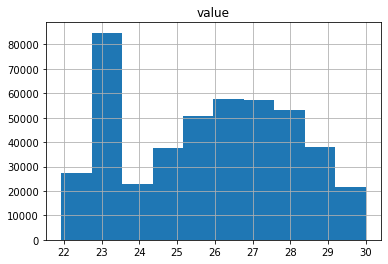

In [36]:
historical_temp.value.describe()
historical_temp.hist("value")

## Seat availability

In [49]:
passenger_count = crowd_historical_df.copy(deep=True)
passenger_count.timestamp = passenger_count.timestamp + 1

    

In [50]:
def calc_seat_availability(passenger_count):
    if 0 < passenger_count <= SEATS_PER_CARRIAGE:
        lower_bound = SEATS_PER_CARRIAGE - passenger_count
        upper_bound = SEATS_PER_CARRIAGE
    else:
        lower_bound = 0
        upper_bound = 0

    return random.randint(lower_bound, upper_bound)

passenger_count["value"] = passenger_count.value.apply(calc_seat_availability)
passenger_count["comfort_indicator"] = "seat"
passenger_count

,timestamp,value,carriage_id,comfort_indicator
0,1633017909,18,1,seat
1,1633018163,20,1,seat
2,1633018506,0,1,seat
3,1633018591,0,1,seat
4,1633018904,0,1,seat
...,...,...,...,...
283,1666884734,17,4,seat
284,1666884755,20,4,seat
285,1666884820,18,4,seat
286,1666886099,19,4,seat


## Combine all

In [56]:
historical_combined = pd.DataFrame()

historical_combined = pd.concat([historical_combined, crowd_historical_df, historical_temp, passenger_count])
historical_combined.timestamp = historical_combined.timestamp.apply(convert_epoch_to_datetime)

historical_combined.to_csv("../data/intermediate/historical_combined.csv", index=False, encoding="utf_8_sig")

historical_combined

,timestamp,value,carriage_id,comfort_indicator
0,2021-10-01 00:05:08,2.0,1,crowd
1,2021-10-01 00:09:22,2.0,1,crowd
2,2021-10-01 00:15:05,0.0,1,crowd
3,2021-10-01 00:16:30,0.0,1,crowd
4,2021-10-01 00:21:43,0.0,1,crowd
...,...,...,...,...
283,2022-10-27 23:32:14,17.0,4,seat
284,2022-10-27 23:32:35,20.0,4,seat
285,2022-10-27 23:33:40,18.0,4,seat
286,2022-10-27 23:54:59,19.0,4,seat


## Graph

In [ ]:
import matplotlib
from datetime import datetime

def plot_graph(df):
    # plt.style.use("fivethirtyeight")
 
    plt.figure(figsize=(12, 10))
    # df["time"] = df["time"].astype("datetime64[ns]")
    # df.time = pd.to_datetime(df.time)
    # x = [datetime.time(0,0,0), datetime.time(23,59,59)]
    # x_dt = [datetime.datetime.combine(datetime.date.today(), t) for t in x]
    # df['time'] = df['time'].apply(pd.Timestamp.timestamp)


    # df.plot()
    plt.plot(df.time, df.value)

plot_graph(test)

comfort_indicator | timestamp | carriage_id | id | value

In [5]:
from datetime import datetime
datetime.now().timestamp()

1666929390.338258

In [ ]:

from datetime import datetime, time, timedelta
from random import randrange


PROMPT = 'Please enter a {} time in ISO format: '


def read_time(prompt: str) -> time:
    """Reads a time object from the user."""

    return time.fromisoformat(input(prompt))


def rand_datetime(start: datetime, end: datetime) -> datetime:
    """Returns a random datetime between start and end."""

    return datetime.fromtimestamp(randrange(round(start.timestamp()), round(end.timestamp())))


def rand_time(start: time, end: time) -> time:
    """Returns a random time between start and end."""

    return rand_datetime(
        datetime.combine(dt0 := datetime.fromtimestamp(0), start),
        datetime.combine(dt0 if start < end else dt0 + timedelta(days=1), end)).time()


def main():
    """Runs the script."""

    start = read_time(PROMPT.format('first'))
    end = read_time(PROMPT.format('second'))
    rand = rand_time(start, end)
    print('Your random time:', rand)


if __name__ == '__main__':
    main()

In [ ]:
# Python3 code to demonstrate working of
# Random K dates in Range
# Using randrange() + timedelta() + loop
from datetime import date, timedelta
import random

# initializing dates ranges
test_date1, test_date2 = date(2021, 10, 1), datetime.today().date()

# printing dates
print("The original range : " + str(test_date1) + " " + str(test_date2))

# initializing K
K = 7

# getting days between dates
dates_bet = test_date2 - test_date1
total_days = dates_bet.days

res = []
for idx in range(K):
	random.seed(a=None)
	
	# getting random days
	randay = random.randrange(total_days)
	
	# getting random dates
	res.append(test_date1 + timedelta(days=randay))

# printing
print("K random dates in range : " + str(res))


In [ ]:
from datetime import date
